In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity

pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

In [30]:
# Load dataset
df = pd.read_csv("./dataset/data.csv")
df.head()

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


In [31]:
# Overview
df.info()

# Summary statistics
df.describe()

# Shape
print("Shape:", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2017 non-null   int64  
 1   acousticness      2017 non-null   float64
 2   danceability      2017 non-null   float64
 3   duration_ms       2017 non-null   int64  
 4   energy            2017 non-null   float64
 5   instrumentalness  2017 non-null   float64
 6   key               2017 non-null   int64  
 7   liveness          2017 non-null   float64
 8   loudness          2017 non-null   float64
 9   mode              2017 non-null   int64  
 10  speechiness       2017 non-null   float64
 11  tempo             2017 non-null   float64
 12  time_signature    2017 non-null   float64
 13  valence           2017 non-null   float64
 14  target            2017 non-null   int64  
 15  song_title        2017 non-null   object 
 16  artist            2017 non-null   object 


In [32]:
# Check missing values
print(df.isnull().sum())

# Check duplicates and drop
print("Duplicate rows:", df.duplicated().sum())
df = df.drop_duplicates()

Unnamed: 0          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
target              0
song_title          0
artist              0
dtype: int64
Duplicate rows: 0


In [33]:
# Drop rows with missing data (if any)
df = df.dropna()

# Confirm cleanup
print("Remaining nulls:", df.isnull().sum().sum())

Remaining nulls: 0


In [34]:
# Outlier Treatment (Clipping)
for col in ['loudness', 'tempo', 'duration_ms']:
    lower_bound = df[col].quantile(0.01)
    upper_bound = df[col].quantile(0.99)
    df[col] = np.clip(df[col], lower_bound, upper_bound)
    print(f"Clipped outliers for: {col}")

Clipped outliers for: loudness
Clipped outliers for: tempo
Clipped outliers for: duration_ms


In [35]:
# Create the target variable: preference_score
# Convert classification label (target) to float and add tiny random noise
df['preference_score'] = df['target'].astype(float) + np.random.uniform(-0.05, 0.05, size=len(df))

### 2. Exploratory Data Analysis (EDA) & Visualizations

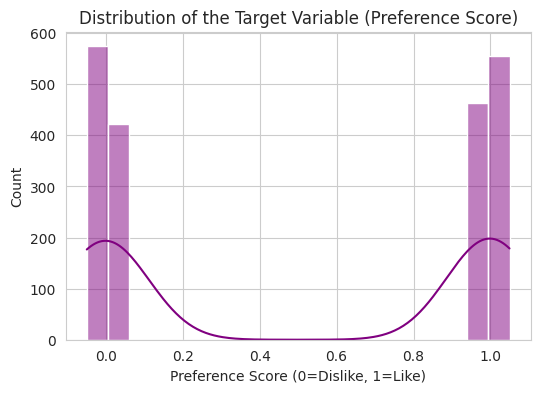

In [36]:
# Visualization 1: Target Distribution
plt.figure(figsize=(6, 4))
sns.histplot(df['preference_score'], bins=20, kde=True, color='purple')
plt.title("Distribution of the Target Variable (Preference Score)")
plt.xlabel("Preference Score (0=Dislike, 1=Like)")
plt.show()

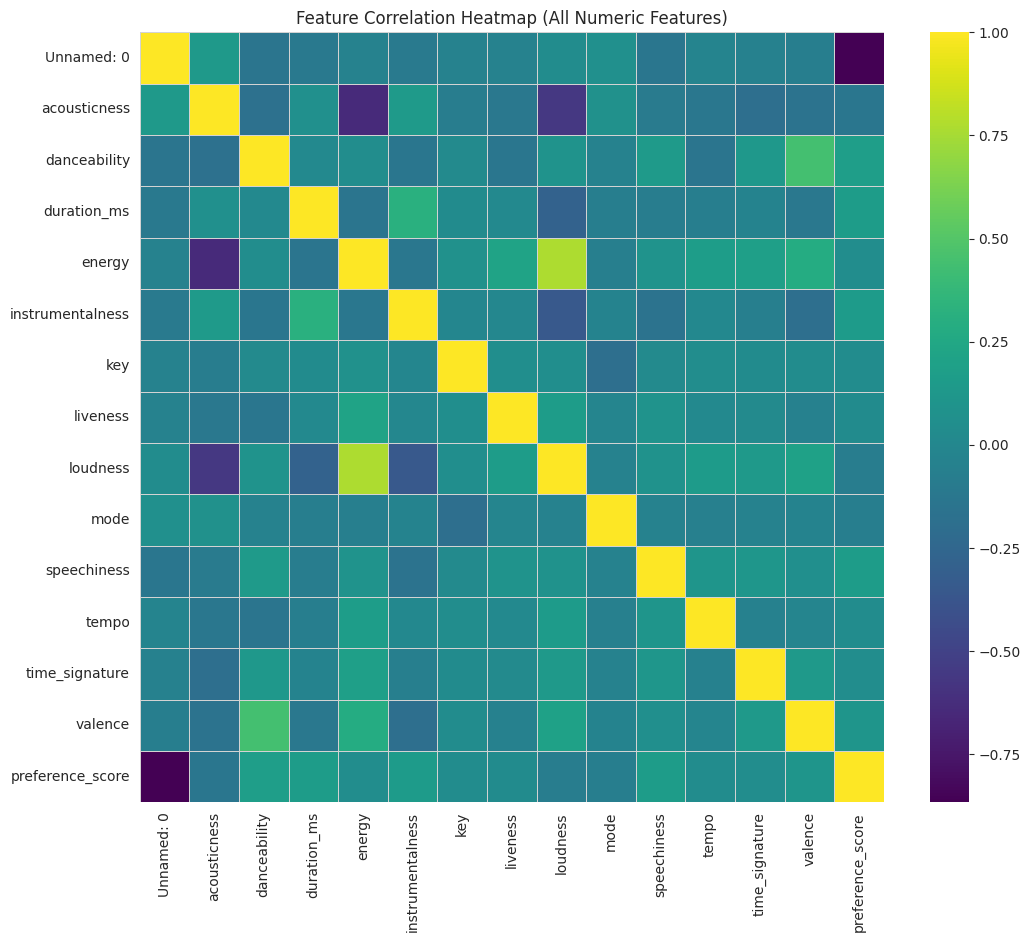

In [37]:
# Identify numeric features for correlation
numeric_features = df.select_dtypes(include=[np.number]).drop(columns=['target'])

# Visualization 2: Feature Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_features.corr(), cmap='viridis', annot=False, linewidths=0.5, linecolor='lightgray')
plt.title("Feature Correlation Heatmap (All Numeric Features)")
plt.show()

### 3. Automated Feature Selection (RFE)

In [38]:
# Prepare data for Feature Selection
# Exclude non-feature columns (ID, names, and the new preference_score target)
exclude_cols = ['id', 'uri', 'track_href', 'analysis_url', 'type', 'song_title', 'artist', 'target', 'preference_score']
candidate_features = df.select_dtypes(include=[np.number]).drop(columns=exclude_cols, errors='ignore').columns.tolist()

X_candidate = df[candidate_features]
y_rfe = df['preference_score']

# Scale candidate features for RFE stability
scaler_rfe = StandardScaler()
X_scaled_rfe = scaler_rfe.fit_transform(X_candidate)
X_scaled_rfe = pd.DataFrame(X_scaled_rfe, columns=candidate_features)

In [39]:
# Use Recursive Feature Elimination (RFE) with Linear Regression
estimator = LinearRegression()
# We aim to select the top 8 features as an example
rfe = RFE(estimator, n_features_to_select=8, step=1)
rfe.fit(X_scaled_rfe, y_rfe)

# Get the selected features
selected_features = X_scaled_rfe.columns[rfe.support_].tolist()
print(f"Automatically Selected Features (RFE): {selected_features}")

Automatically Selected Features (RFE): ['Unnamed: 0', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'loudness', 'speechiness', 'valence']


In [40]:
# Final feature and target setup
X = df[selected_features]
y = df['preference_score']

# Scale the final features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
### 4. Model Training and Evaluation

In [41]:
# Create Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f"Train set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

Train set size: 1613, Test set size: 404


In [42]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Store results
results = []

In [43]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

results = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R² Score": r2
    })

# Convert to DataFrame for clean view
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:\n")
print(results_df.sort_values(by='R² Score', ascending=False).to_string(index=False))


Model Performance Comparison:

            Model      MAE     RMSE  R² Score
    Random Forest 0.025287 0.029278  0.996562
Gradient Boosting 0.025515 0.029488  0.996513
Linear Regression 0.190614 0.233351  0.781632


/tmp/ipykernel_94695/3569723661.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="R² Score", data=results_df.sort_values(by='R² Score', ascending=False), palette='viridis')


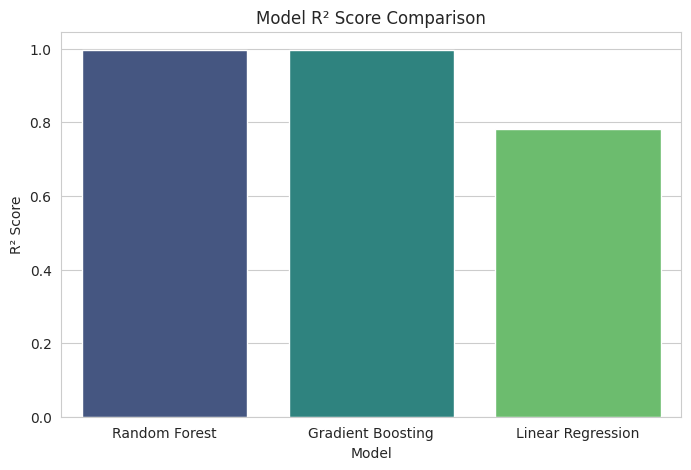

In [44]:
# Visualization 3: Model Performance Comparison
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="R² Score", data=results_df.sort_values(by='R² Score', ascending=False), palette='viridis')
plt.title("Model R² Score Comparison")
plt.ylabel("R² Score")
plt.show()

### 5. Recommendation System & Visualization

In [45]:
# Pick the best-performing model
best_model_name = results_df.sort_values(by='R² Score', ascending=False).iloc[0]['Model']
best_model = models[best_model_name]
print(f"Using the best model for recommendations: **{best_model_name}**")

Using the best model for recommendations: **Random Forest**


In [ ]:

# Predict preference scores for all songs
df['predicted_score'] = best_model.predict(scaler.transform(df[selected_features]))

In [48]:
# Define a function to recommend top N songs
def recommend_songs_enhanced(song_name, top_n=5, weight_pred=0.7, weight_sim=0.3):
    if song_name not in df['song_title'].values:
        print(f"❌ Song '{song_name}' not found in dataset.")
        return None

    input_features = df[df['song_title'] == song_name][selected_features]
    input_scaled = scaler.transform(input_features)

    # Compute similarity (using features used by the model)
    similarities = cosine_similarity(input_scaled, scaler.transform(df[selected_features]))[0]
    df['similarity'] = similarities

    # Combine predicted liking and feature similarity
    df['combined_score'] = (
        weight_pred * df['predicted_score'] + weight_sim * df['similarity']
    )

    # Exclude the same song and get top N
    recommendations = (
        df[df['song_title'] != song_name]
        .sort_values('combined_score', ascending=False)
        [['song_title', 'artist', 'combined_score']]
        .head(top_n)
    )

    print(f"\n🎶 Top {top_n} Recommended Songs similar to '{song_name}':\n")
    return recommendations.reset_index(drop=True)

In [49]:
# Show first 20 song titles to choose from
print(df['song_title'].head(20).to_string(index=False))

                            Mask Off
                             Redbone
                        Xanny Family
                      Master Of None
                      Parallel Lines
                            Sneakin’
                         Childs Play
                     Gyöngyhajú lány
                   I've Seen Footage
                      Digital Animal
Subways - In Flagranti Extended Edit
          Donme Dolap - Baris K Edit
                             Cemalim
                           One Night
                             Oh lala
                                Char
                     World In Motion
           One Nation Under a Groove
                             Bouncin
                C O O L - Radio Edit



🎶 Top 5 Recommended Songs similar to 'I'm a Dildo':



/tmp/ipykernel_94695/1178945251.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=recs['song_title'], x=recs['combined_score'], palette='ocean')
/mnt/storage/Repos/Music-Taste-Predictor/env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127911 (\N{HEADPHONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


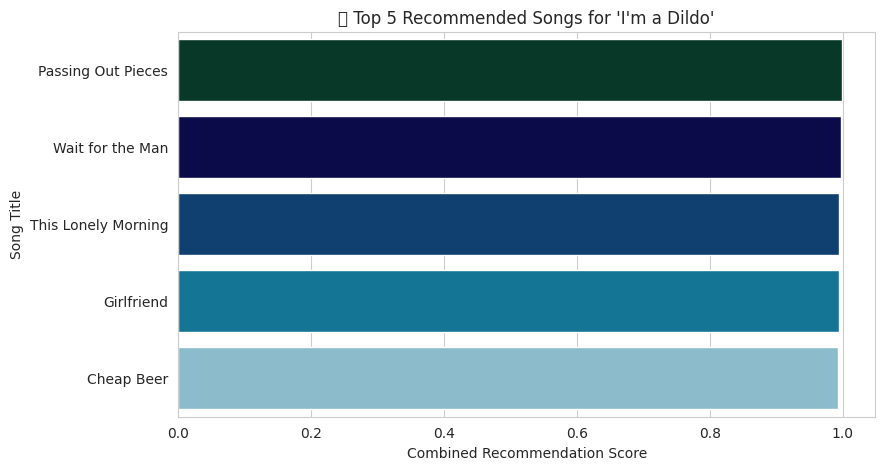

In [60]:
# Visualization 4: Example Recommendation
recommendation_song = df['song_title'].sample(1).iloc[0] # Pick a random song for demo
recs = recommend_songs_enhanced(recommendation_song, top_n=5)

if recs is not None:
    plt.figure(figsize=(9, 5))
    sns.barplot(y=recs['song_title'], x=recs['combined_score'], palette='ocean')
    plt.title(f"🎧 Top 5 Recommended Songs for '{recommendation_song}'")
    plt.xlabel("Combined Recommendation Score")
    plt.ylabel("Song Title")
    plt.show()